## Project Overview: Time Reproduction Analysis

- **Notebook**: `SDTUANA.ipynb` | **Date**: 2025-04-28  
- **Contact**: chunyu.qu@tum.de | **Environment**: Python 3.12.7  

---

### 0. Initialization & Data Preparation  
Module import, path setup, batch CSV loading, data cleaning (unit conversion, outlier removal, trial-wise variable construction)

### 1. Quality Control  
Histograms, Q-Q plots, subject-level trial counts, coefficient of variation (CV) and SD distribution checks

### 2. Reproduction Bias  
Compute current bias (`curBias = rpr - curDur`), subject-level mean bias, CV and SD trends by duration

### 3. Central Tendency  
Examine systematic under/overestimation across different target durations

### 4. Serial Dependence  
Analyze whether current bias is affected by previous information`

### 5. Decisional Carryover Effect (DCI)  
Construct `preRpt`, plot bias variation under repetition × uncertainty conditions

### 6. n-back SDI  
Generate 2–10 back predictors, compute serial dependence index (SDI) slope across lags, compare between high vs. low uncertainty

### 7. Linear Mixed Models  
Fit LMMs: `curBias ~ TimeDur_prev * TransitionType + (1|subID)`, interpret fixed effects and subject-level variance

### 8. Deviation Index (DVI)  
Compute `DVI = rpr - subject_mean(curDur)`, plot DVI against `diffDur` (overall and sequences)

---


### 0.1 Environment preparation

In [324]:
# Import required libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from io import StringIO
import pymc as pm
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import warnings

### 0.2 Loading the data

In [325]:
#  Set data paths
data_folder = r'D:/SDMT/DataAna/DATA/'                    # Raw CSV folder


In [368]:
# Function 1 Read and clean all raw CSVs
def basic_cleaning(data_folder):
    all_dfs = []
    for file_path in glob.glob(os.path.join(data_folder, '*.csv')):
        # Read and skip header
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        cleaned_lines = [lines[0]] + lines[33:]
        df = pd.read_csv(StringIO(''.join(cleaned_lines)))

        # Convert keyDuration to seconds
        df['keyDuration'] = df['keyDuration'] / 1000.0
        df['ReproductionError'] = df['keyDuration'] - df['TimeDur']

        # Add subject ID
        sub_id = os.path.basename(file_path).split('_')[0]
        df['subID'] = sub_id

        all_dfs.append(df)

    return pd.concat(all_dfs, ignore_index=True)

df_all = basic_cleaning(data_folder)
# Function 2  Advanced outlier removal per subject (IQR + error limit)
def advanced_iqr_filtering(df_all, error_thresh=0.6):
    filtered_dfs = []
    for sub_id, df_sub in df_all.groupby("subID"):
        q1 = df_sub['keyDuration'].quantile(0.25)
        q3 = df_sub['keyDuration'].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        df_clean = df_sub[
            (df_sub['TimeDur'] >= 0.8) & (df_sub['TimeDur'] <= 1.6) &
            (df_sub['keyDuration'] >= lower_bound) & (df_sub['keyDuration'] <= upper_bound) &
            (df_sub['ReproductionError'].abs() <= error_thresh)
        ].copy()

        filtered_dfs.append(df_clean)

    return pd.concat(filtered_dfs, ignore_index=True)
#  Function 3 plotting histograms for each subject
def plot_histograms(df, column='keyDuration', groupby='subID', bins=30):
    subjects = df[groupby].unique()
    n_cols = 3
    n_rows = int(np.ceil(len(subjects) / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()
    
    for i, sub in enumerate(subjects):
        sub_data = df[df[groupby] == sub][column]
        axes[i].hist(sub_data.dropna(), bins=bins, color='skyblue', edgecolor='black')
        axes[i].set_title(f'{column} Histogram - {sub}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')
    
    # Remove unused subplots
    for ax in axes[len(subjects):]:
        fig.delaxes(ax)
    
    plt.tight_layout()
    plt.show()

#  Function 4 plotting Q-Q plots for each subject
def plot_qqplots(df, column='keyDuration', groupby='subID'):
    subjects = df[groupby].unique()
    n_cols = 3
    n_rows = int(np.ceil(len(subjects) / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, sub in enumerate(subjects):
        sub_data = df[df[groupby] == sub][column].dropna()
        stats.probplot(sub_data, dist="norm", plot=axes[i])
        axes[i].set_title(f'Q-Q Plot - {sub}')
    
    for ax in axes[len(subjects):]:
        fig.delaxes(ax)
    
    plt.tight_layout()
    plt.show()
#  Function 5 build trial-level variables
def construct_trial_variables(df, max_n_back=10, verbose=True):
    """
    clean and construct trial-level variables

    paramiters:
        df (pd.DataFrame): TimeDur, keyDuration...
        max_n_back (int):  n-back variable
        verbose (bool): if True, print the progress

    return:
        df_cleaned (pd.DataFrame):DataFrame
    """

    df = df.copy()

    # rename columns
    df = df.rename(columns={
        'trials.thisN': 'trial_num',
        'TimeDur': 'curDur',
        'keyDuration': 'rpr',
        'ReproductionError': 'curBias',
        'Coherence1': 'curCoherence'
    })

    # add 1-back variables
    df['preDur1back'] = df.groupby('subID')['curDur'].shift(1)
    df['preCoherence1back'] = df.groupby('subID')['curCoherence'].shift(1)

    # build transition type
    def classify_transition(row):
        if pd.isnull(row['preCoherence1back']):
            return np.nan
        prev = 'High' if row['preCoherence1back'] == 0.3 else 'Low'
        curr = 'High' if row['curCoherence'] == 0.3 else 'Low'
        return prev[0] + curr[0]

    df['TransitionType'] = df.apply(classify_transition, axis=1)

    #  add n-back variables
    for n in range(2, max_n_back + 1):
        df[f'preDur{n}back'] = df.groupby('subID')['curDur'].shift(n)
        df[f'preCoherence{n}back'] = df.groupby('subID')['curCoherence'].shift(n)

    # remove rows with missing values in 1-back variables
    df = df.dropna(subset=['preDur1back', 'preCoherence1back']).copy()

    # keep columns
    keep_cols = ['subID', 'trial_num', 'curDur', 'rpr', 'curBias', 'curCoherence',
                 'preDur1back', 'preCoherence1back', 'TransitionType'] + \
                [f'preDur{n}back' for n in range(2, max_n_back + 1)] + \
                [f'preCoherence{n}back' for n in range(2, max_n_back + 1)]

    df_cleaned = df[[col for col in keep_cols if col in df.columns]].copy()

   

    return df_cleaned

# define function to do repeated measures ANOVA with Greenhouse-Geisser corrections
# provided long-format data
def rmANOVA_gg_Long(data, dv, within, subject):
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        if len(within) == 1:
            GGpass = pg.sphericity(data, dv=dv, subject=subject, within=within, method='greenhouse-geisser')[0]
            aov = pg.rm_anova(data=data, dv=dv, within=within, subject=subject, detailed=True, effsize="np2", correction= not GGpass)
            if not GGpass:
                aov['DF-GG-corr'] = aov['DF'] * aov['eps'][0]
                aov.drop(columns=['sphericity', 'W-spher', 'p-spher'], inplace=True)
                print('* The assumption of sphericity is violated for factor:', within)
            return aov
        elif len(within) == 2:
            GGpass = pd.Series([True,True,True])
            factorDict = {"0":within[0], "1":within[1], "2":within}
            for i in range(3):
                GGpass[i] = pg.sphericity(data, dv=dv, subject=subject, within=factorDict[str(i)], method='greenhouse-geisser')[0]
                if not GGpass[i]:
                    print('* The assumption of sphericity is violated for factor:', factorDict[str(i)])
            aov = pg.rm_anova(data=data, dv=dv, within=within, subject=subject, detailed=True, effsize="np2", correction=True)
            eps = pd.Series([1,1,1])
            GGcrr = [not x for x in GGpass]
            eps[GGcrr] = aov['eps'][GGcrr]
            aov['DF1-GGcrr'] = aov['ddof1'] * eps
            aov['DF2-GGcrr'] = aov['ddof2'] * eps
            return aov
        

#  Function 7 plot dvi curve
def plot_dvi_curve(df,
                   time_col='curDur',
                   rpr_col='rpr',
                   prev_col='preDur1back',
                   group_col='subID',
                   transition_col='TransitionType',
                   by_transition=False,
                   min_trials=1,
                   xlim=(-0.9, 0.9),
                   ylim=(-0.15, 0.15),
                   figsize=(12, 8),
                   title=None):
    """
    plot dvi curve
    """
    df = df.copy()

    df['TimeDur'] = df[time_col]
    df['rpr'] = df[rpr_col]
    df['preDur'] = df[prev_col]
    df['subID'] = df[group_col]
    if by_transition:
        df['TransitionType'] = df[transition_col]

    #  DVI accroding the time duration
    df['DVI'] = df['rpr'] - df.groupby(['subID', 'TimeDur'])['rpr'].transform('mean')
    df['diffDur'] = np.round(df['preDur'] - df['TimeDur'], 2)

    if by_transition:
        # multi-panel plot
        fig, axes = plt.subplots(2, 2, figsize=figsize, sharex=True, sharey=True)
        transition_order = ['LL', 'LH', 'HL', 'HH']
        colors = {'LL': 'black', 'LH': 'gray', 'HL': 'blue', 'HH': 'green'}

        for i, trans in enumerate(transition_order):
            row, col = divmod(i, 2)
            ax = axes[row, col]

            data_sub = df[df['TransitionType'] == trans]
            dvi_par = data_sub.groupby(['subID', 'diffDur'])['DVI'].mean().reset_index()
            dvi_group = dvi_par.groupby('diffDur').agg(
                count=('DVI', 'count'),
                mean_DVI=('DVI', 'mean'),
                sem_DVI=('DVI', 'sem')
            ).reset_index()
            dvi_group = dvi_group[dvi_group['count'] >= min_trials]

            ax.errorbar(
                x=dvi_group['diffDur'],
                y=dvi_group['mean_DVI'],
                yerr=dvi_group['sem_DVI'],
                color=colors[trans],
                capsize=4,
                label=trans
            )
            ax.axhline(0, color='black', linestyle='--')
            ax.set_title(f'Transition: {trans}')
            ax.set_xlim(*xlim)
            ax.set_ylim(*ylim)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            if col == 0:
                ax.set_ylabel('Deviation Index (DVI)')
            if row == 1:
                ax.set_xlabel('Δ Duration (prev - curr) [s]')

        plt.suptitle(title or 'Sequential Effect: DVI by Transition Type', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    else:
        dvi_par = df.groupby(['subID', 'diffDur'])['DVI'].mean().reset_index()
        dvi_group = dvi_par.groupby('diffDur').agg(
            count=('DVI', 'count'),
            mean_DVI=('DVI', 'mean'),
            sem_DVI=('DVI', 'sem')
        ).reset_index()
        dvi_group = dvi_group[dvi_group['count'] >= min_trials]

        fig, ax = plt.subplots(figsize=(7, 5))
        ax.errorbar(
            x=dvi_group['diffDur'],
            y=dvi_group['mean_DVI'],
            yerr=dvi_group['sem_DVI'],
            fmt='o-', color='black', capsize=4,
            label='Mean ± SEM'
        )
        ax.axhline(0, linestyle='--', color='gray')
        ax.set_xlabel('Pre - Current Duration (s)')
        ax.set_ylabel('Deviation Index (DVI)')
        ax.set_title(title or 'Overall Sequential Effect (DVI)')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
        plt.legend()
        plt.tight_layout()
        plt.show()

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import shapiro, norm

def plot_histograms_with_normal_curve(df, column='keyDuration', groupby='subID', bins=30):
    subjects = df[groupby].unique()
    n_cols = 3
    n_rows = int(np.ceil(len(subjects) / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()
    
    for i, sub in enumerate(subjects):
        sub_data = df[df[groupby] == sub][column].dropna()
        ax = axes[i]
        
        # plot histogram
        counts, bins_edges, _ = ax.hist(sub_data, bins=bins, density=True, 
                                        color='skyblue', edgecolor='black', alpha=0.7)
        
        # calculate normal distribution parameters
        if len(sub_data) >= 3:
            stat, p = shapiro(sub_data)
            normal = 'Yes' if p > 0.05 else 'No'
            title = f'{column} - {sub}\np={p:.3f}, Normal? {normal}'
            
            # plot normal distribution curve
            mu, std = np.mean(sub_data), np.std(sub_data)
            x = np.linspace(min(sub_data), max(sub_data), 100)
            y = norm.pdf(x, mu, std)
            ax.plot(x, y, color='red', linestyle='--', label='Normal Curve')
            ax.legend()
        else:
            title = f'{column} - {sub}\n(Too few data)'
        
        ax.set_title(title)
        ax.set_xlabel(column)
        ax.set_ylabel('Density')
    
    for ax in axes[len(subjects):]:
        fig.delaxes(ax)
    
    plt.tight_layout()
    plt.show()



##  1. Qulity Control:Distribution & Individual Differences

In [327]:
df_all = basic_cleaning(data_folder)
print("filter trial number:")
print(df_all['subID'].value_counts())
df_cleaned = advanced_iqr_filtering(df_all)
print("filter trial number:")
print(df_cleaned['subID'].value_counts())


filter trial number:
subID
182072    240
885939    240
Name: count, dtype: int64
filter trial number:
subID
182072    237
885939    212
Name: count, dtype: int64


In [328]:
df_cleaned = advanced_iqr_filtering(df_all)
trialn = df_cleaned['subID'].value_counts().sort_index()
trialr = trialn / 240
result_df = pd.DataFrame({
    'subID': trialn.index,'trial_count': trialn.values,'trial_ratio': trialr.values})

print(result_df)


    subID  trial_count  trial_ratio
0  182072          237     0.987500
1  885939          212     0.883333


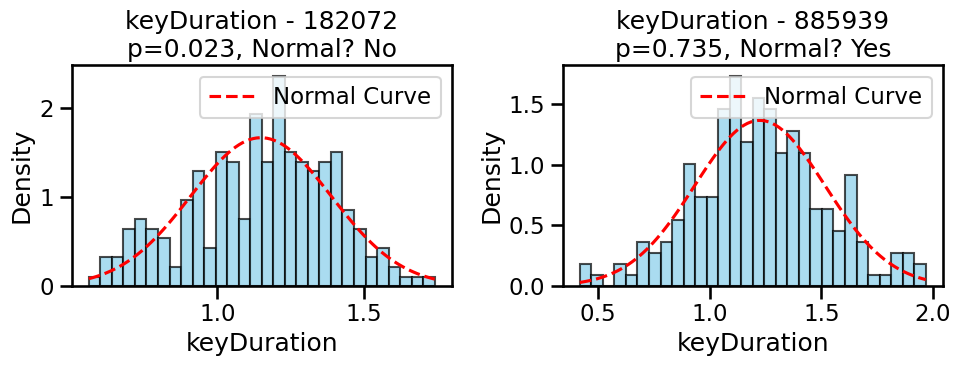

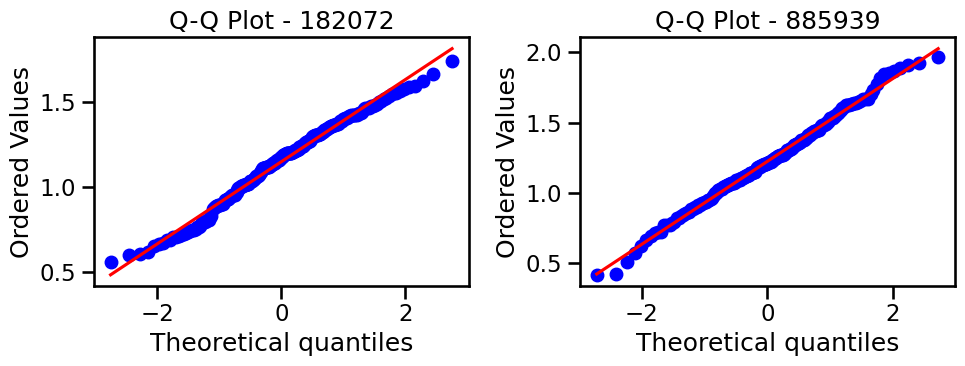

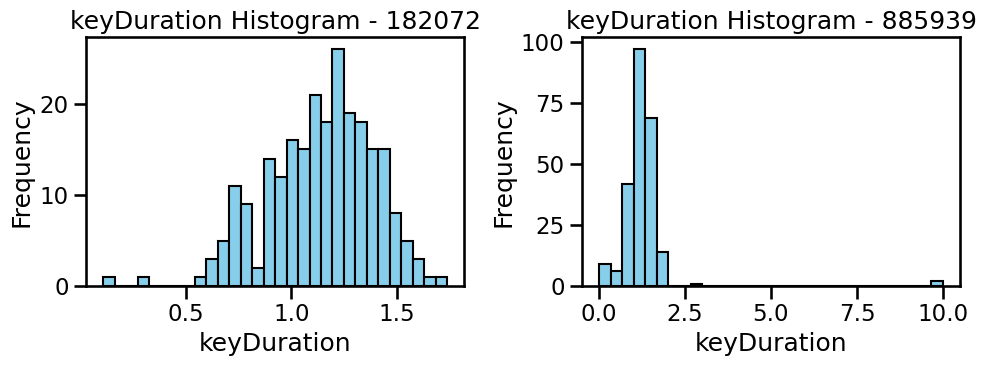

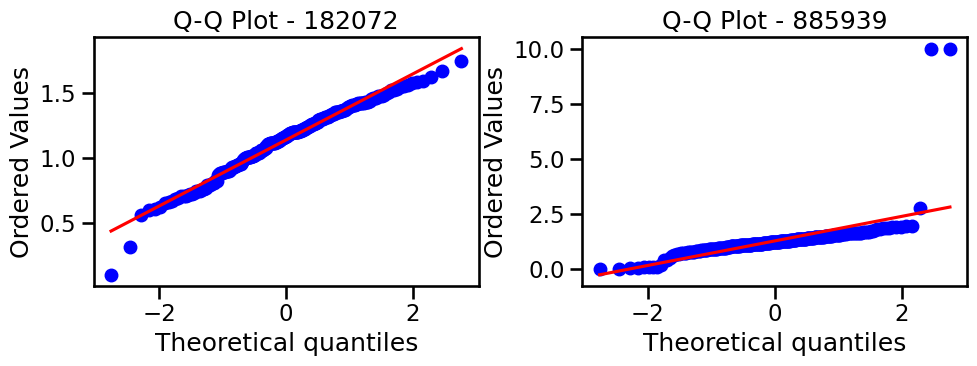

In [329]:
# histogram and qqplot for keyDuration
plot_histograms_with_normal_curve(df_cleaned, column='keyDuration', groupby='subID')
plot_qqplots(df_cleaned, column='keyDuration', groupby='subID')
plot_histograms(df_all, column='keyDuration', groupby='subID')
plot_qqplots(df_all, column='keyDuration', groupby='subID')

In [330]:
#view cleaned data
df = construct_trial_variables(df_cleaned)
df.head()

,subID,trial_num,curDur,rpr,curBias,curCoherence,preDur1back,preCoherence1back,TransitionType,preDur2back,...,preDur10back,preCoherence2back,preCoherence3back,preCoherence4back,preCoherence5back,preCoherence6back,preCoherence7back,preCoherence8back,preCoherence9back,preCoherence10back
1,182072,31,1.6,1.1146,-0.4854,0.3,1.4,0.3,HH,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,182072,33,1.0,0.7059,-0.2941,0.7,1.6,0.3,HL,1.4,...,NaN,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,182072,34,0.8,0.6063,-0.1937,0.3,1.0,0.7,LH,1.6,...,NaN,0.3,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,182072,35,1.2,0.6638,-0.5362,0.3,0.8,0.3,HH,1.0,...,NaN,0.7,0.3,0.3,NaN,NaN,NaN,NaN,NaN,NaN
5,182072,36,1.4,1.0245,-0.3755,0.7,1.2,0.3,HL,0.8,...,NaN,0.3,0.7,0.3,0.3,NaN,NaN,NaN,NaN,NaN


In [331]:
df

,subID,trial_num,curDur,rpr,curBias,curCoherence,preDur1back,preCoherence1back,TransitionType,preDur2back,...,preDur10back,preCoherence2back,preCoherence3back,preCoherence4back,preCoherence5back,preCoherence6back,preCoherence7back,preCoherence8back,preCoherence9back,preCoherence10back
1,182072,31,1.6,1.1146,-0.4854,0.3,1.4,0.3,HH,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,182072,33,1.0,0.7059,-0.2941,0.7,1.6,0.3,HL,1.4,...,NaN,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,182072,34,0.8,0.6063,-0.1937,0.3,1.0,0.7,LH,1.6,...,NaN,0.3,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,182072,35,1.2,0.6638,-0.5362,0.3,0.8,0.3,HH,1.0,...,NaN,0.7,0.3,0.3,NaN,NaN,NaN,NaN,NaN,NaN
5,182072,36,1.4,1.0245,-0.3755,0.7,1.2,0.3,HL,0.8,...,NaN,0.3,0.7,0.3,0.3,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,885939,265,1.4,1.8196,0.4196,0.3,1.6,0.7,LH,1.2,...,1.6,0.3,0.3,0.7,0.3,0.7,0.7,0.7,0.3,0.7
445,885939,266,1.6,1.5696,-0.0304,0.7,1.4,0.3,HL,1.6,...,1.6,0.7,0.3,0.3,0.7,0.3,0.7,0.7,0.7,0.3
446,885939,267,1.4,1.6664,0.2664,0.7,1.6,0.7,LL,1.4,...,1.2,0.3,0.7,0.3,0.3,0.7,0.3,0.7,0.7,0.7
447,885939,268,1.2,1.6682,0.4682,0.3,1.4,0.7,LH,1.6,...,0.8,0.7,0.3,0.7,0.3,0.3,0.7,0.3,0.7,0.7


## 2  reproduction bias


In [332]:
# reproduction bias for each subject
genRprBias = df.groupby('subID')['curBias'].mean().reset_index()

print(genRprBias)

# Generallized Reproduction Bias
print('mean rpr Bias:', genRprBias['curBias'].mean().round(3))
print('SE of rpr Bias:', genRprBias['curBias'].sem().round(3))


    subID   curBias
0  182072 -0.051869
1  885939  0.003949
mean rpr Bias: -0.024
SE of rpr Bias: 0.028


In [333]:
# 1 reproduction CV（Coefficient of Variation）

RprCV = df.groupby('subID').agg({'rpr': ['count', 'mean', 'std']}).reset_index()
RprCV.columns = ['subID', 'count', 'mean', 'std']
RprCV['cv'] = RprCV['std'] / RprCV['mean']

print(RprCV)

# overall CV
print('mean of overall CV:', RprCV['cv'].mean().round(3))
print('SE of overall CV:', RprCV['cv'].sem().round(3))

# t-test
import pingouin as pg
print(pg.ttest(RprCV['cv'], 0).round(3))

    subID  count      mean       std        cv
0  182072    236  1.148978  0.240057  0.208931
1  885939    211  1.224802  0.293628  0.239735
mean of overall CV: 0.224
SE of overall CV: 0.015
             T  dof alternative  p-val         CI95%  cohen-d   BF10 power
T-test  14.565    1   two-sided  0.044  [0.03, 0.42]   10.299  2.497   NaN


In [334]:
# 2️ current duration reproduction CV

mCVPar = df.groupby(['subID', 'curDur']).agg({'rpr': ['count', 'mean', 'std']}).reset_index()
mCVPar.columns = ['subID', 'curDur', 'count', 'mean', 'std']
mCVPar['cv'] = mCVPar['std'] / mCVPar['mean']


mCVAll = mCVPar.groupby('curDur').agg({'cv': ['count', 'mean', 'sem']
}).reset_index()
mCVAll.columns = ['curDur', 'count', 'mCV', 'seCV']

print(mCVAll)

   curDur  count       mCV      seCV
0     0.8      2  0.226760  0.049389
1     1.0      2  0.155280  0.023283
2     1.2      2  0.166124  0.038383
3     1.4      2  0.138672  0.035731
4     1.6      2  0.143074  0.029310


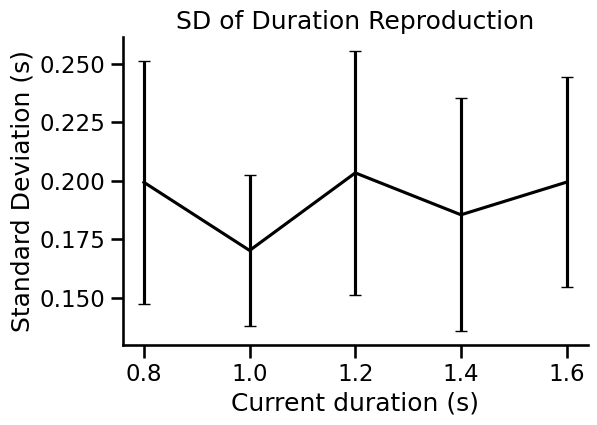

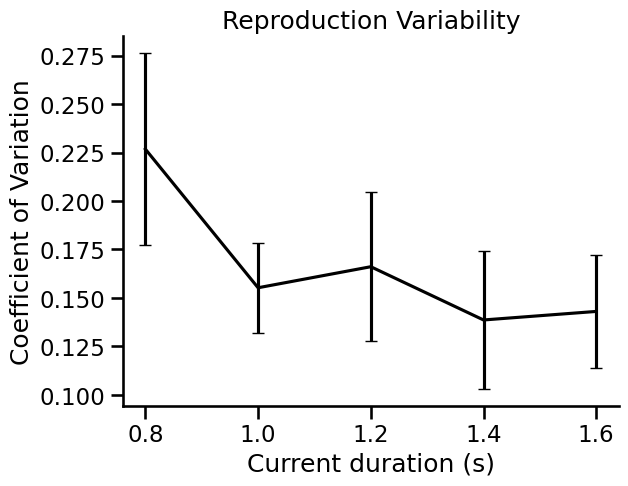

In [335]:
# plot SD vs current duration
mSDAll = mCVPar.groupby('curDur').agg({'std': ['count', 'mean', 'sem']}).reset_index()
mSDAll.columns = ['curDur', 'count', 'mSD', 'seSD']

fig, ax = plt.subplots(figsize=(6, 4))
plt.errorbar(x='curDur', y='mSD', yerr='seSD', data=mSDAll, color='black', capsize=4)
plt.xticks(mSDAll['curDur'])
plt.xlabel('Current duration (s)')
plt.ylabel('Standard Deviation (s)')
plt.title('SD of Duration Reproduction')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()
# plot CV vs current duration
fig, ax = plt.subplots()
plt.errorbar(x='curDur', y='mCV', yerr='seCV', data=mCVAll, color='black', capsize=4)
plt.xticks(mCVAll['curDur'])
plt.xlabel('Current duration (s)')
plt.ylabel('Coefficient of Variation')
plt.title('Reproduction Variability')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


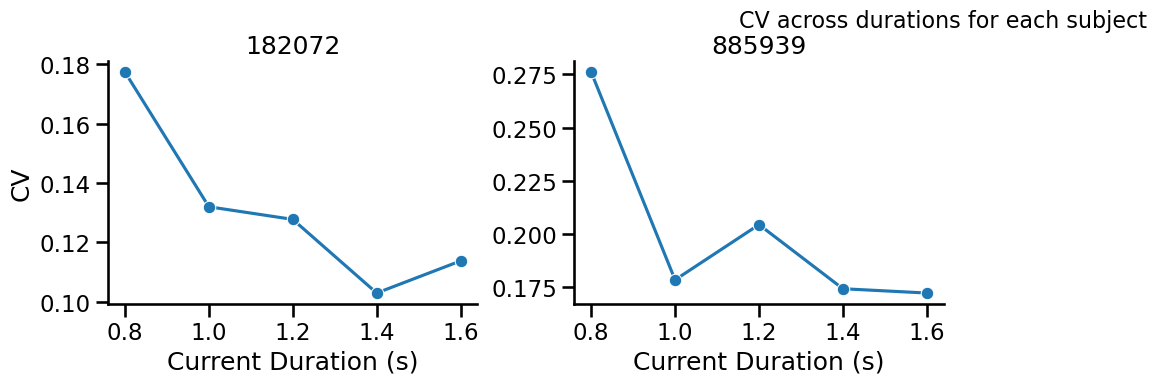

In [336]:
g = sns.relplot(
    data = mCVPar,kind = 'line', x = 'curDur',y = 'cv', col = 'subID', col_wrap = 4,marker = 'o',
    facet_kws={'sharey': False}, 
    height = 4,
    aspect = 1.2
)

g.set_axis_labels("Current Duration (s)", "CV")
g.set_titles("{col_name}") 
plt.subplots_adjust(top=0.85) 
g.fig.suptitle('CV across durations for each subject', fontsize=16)
plt.show()


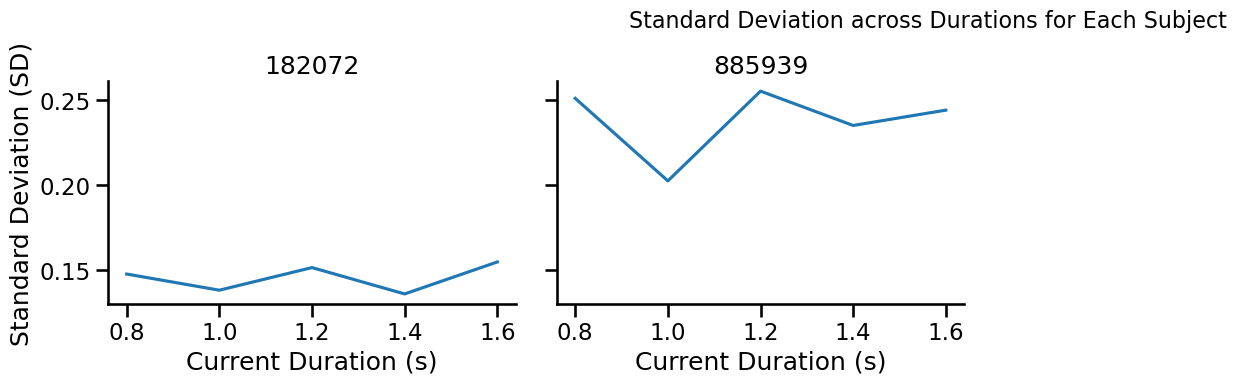

In [337]:
mSDPar = df.groupby(['subID', 'curDur']).agg(count=('rpr', 'count'), std=('rpr', 'std')).reset_index()
mSDPar['seSD'] = mSDPar['std'] / np.sqrt(mSDPar['count'])

# 使用 catplot 绘制分面图
g = sns.relplot( data=mSDPar, kind='line', x='curDur', y='std', col='subID',
    col_wrap=4,  height=4, aspect=1.2)

g.set_axis_labels("Current Duration (s)", "Standard Deviation (SD)")
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.8)
g.fig.suptitle("Standard Deviation across Durations for Each Subject", fontsize=16)
plt.show()


##  3 Central tendency effect


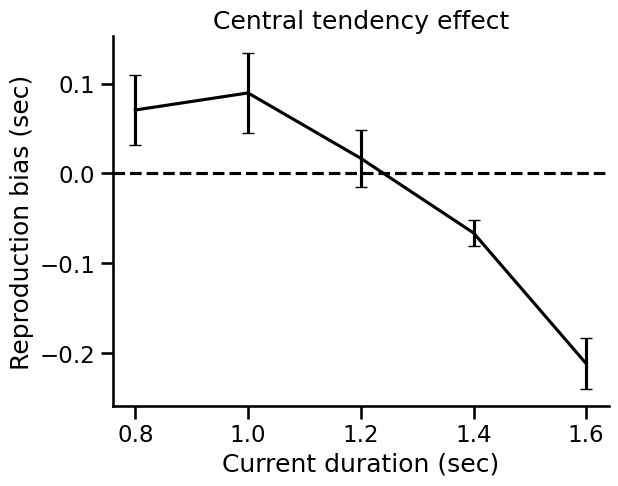

   curDur  count      mRpr     seRpr
0     0.8      2  0.870487  0.038878
1     1.0      2  1.089486  0.044189
2     1.2      2  1.216606  0.032052
3     1.4      2  1.333500  0.014602
4     1.6      2  1.387778  0.028551


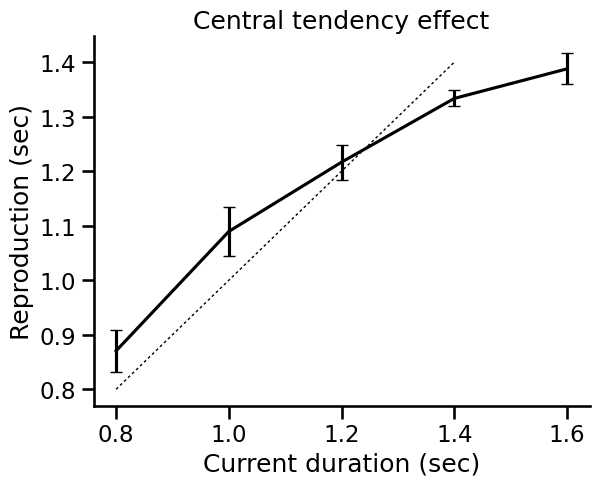

In [338]:
# Central tendency based on Reproduction Bias
mBiasDurPar = df.groupby(['subID', 'curDur']).curBias.mean().reset_index()
mBiasDurAll = mBiasDurPar.groupby('curDur').\
    agg({"curBias":["count","mean","sem"]}).reset_index()
mBiasDurAll.columns = ['curDur', 'count', 'mBias','seBias']
#print(mBiasDurAll)

# rmANOVA: mean bias as a factor of duration
# print('【rmANOVA: Duration main effect on mean bias】')
# aov_bias_dur = rmANOVA_gg_Long(mBiasDurPar, 'curBias', ['curDur'], 'nPar')
# print(aov_bias_dur)

# plot central tendency
fig, ax = plt.subplots()
plt.errorbar(x='curDur', y='mBias', yerr='seBias', data=mBiasDurAll, 
             color='black', capsize=4)
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(mBiasDurAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Reproduction bias (sec)')
plt.title('Central tendency effect')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# # Central tendency based on Reproduction
mRprDurPar = df.groupby(['subID', 'curDur']).rpr.mean().reset_index()
mRprDurAll = mRprDurPar.groupby('curDur').\
     agg({"rpr":["count","mean","sem"]}).reset_index()
mRprDurAll.columns = ['curDur', 'count', 'mRpr','seRpr']
print(mRprDurAll)

 # plot central tendency
fig, ax = plt.subplots()
plt.errorbar(x='curDur', y='mRpr', yerr='seRpr', data=mRprDurAll, 
              color='black', capsize=4)
plt.plot([0.8, 1.4], [0.8, 1.4], 'k-', lw=1, dashes=[2, 2])
plt.xticks(mRprDurAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Reproduction (sec)')
plt.title('Central tendency effect')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

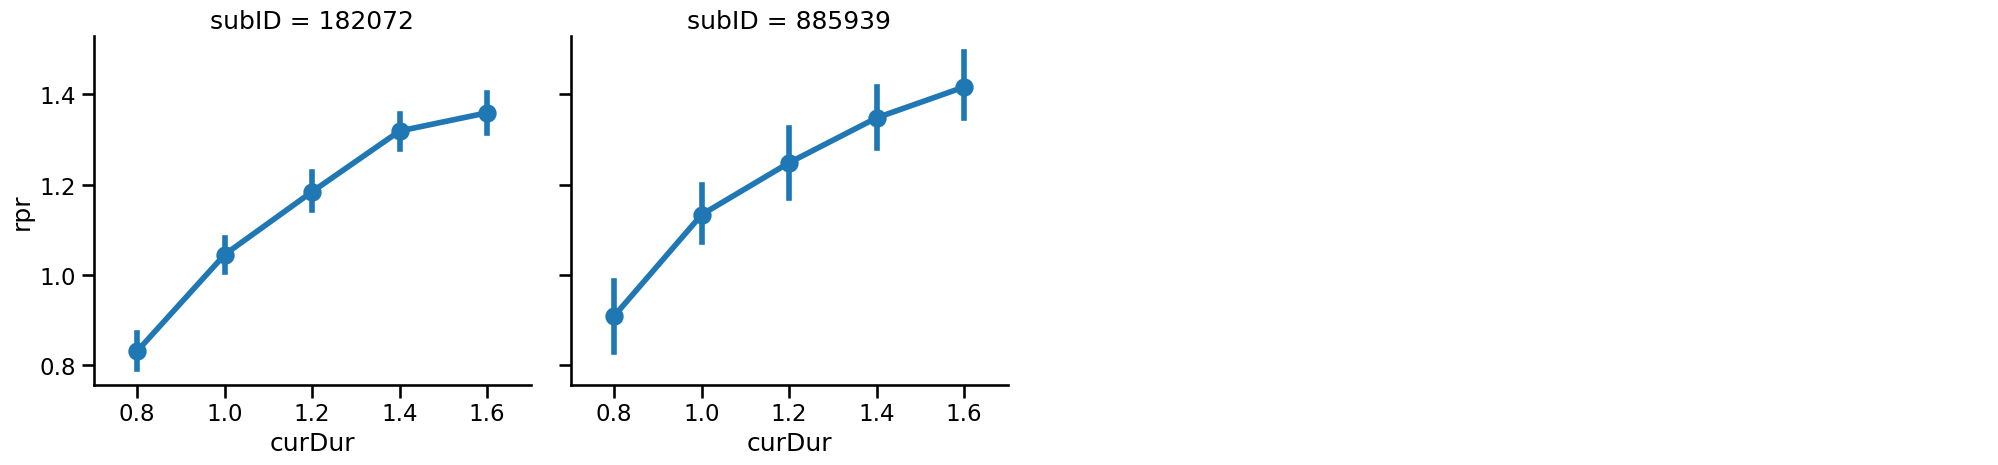

In [339]:
sns.catplot(data = df, kind = 'point', 
            x = 'curDur', y = 'rpr', col = 'subID', col_wrap = 4)

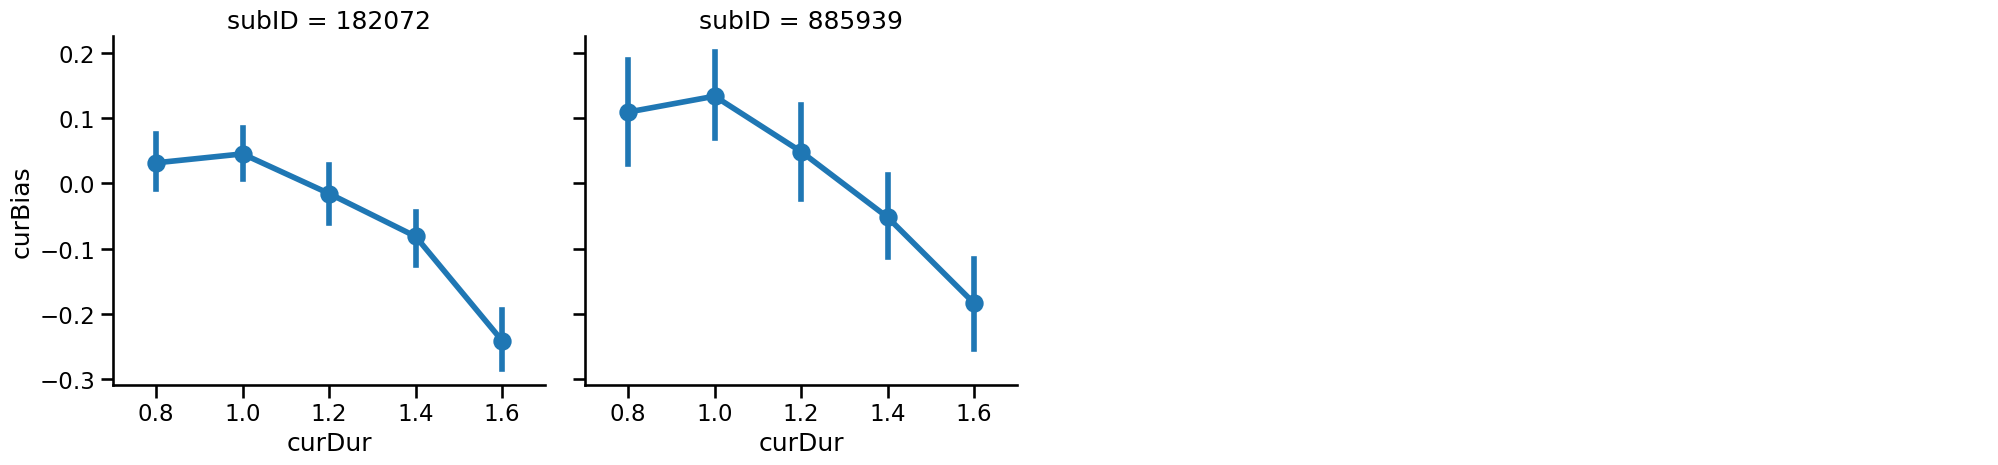

In [340]:
sns.catplot(data = df, kind = 'point', 
            x = 'curDur', y = 'curBias', col = 'subID', col_wrap = 4)

In [341]:
print(df['curCoherence'].value_counts())


curCoherence
0.7    224
0.3    223
Name: count, dtype: int64


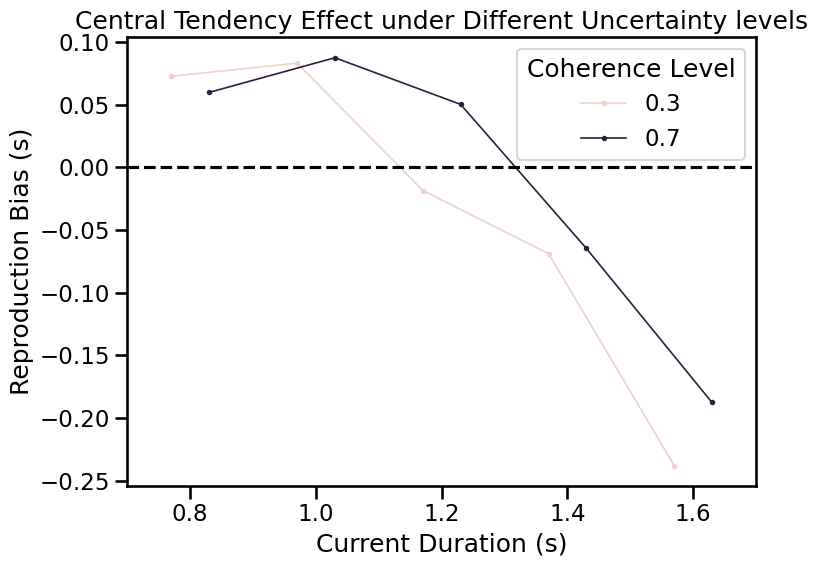

In [342]:

# Group by Uncertainty level
bias_grouped = df.groupby(['curCoherence', 'curDur'])['curBias'] \
    .agg(['count', 'mean', 'sem']).reset_index()
bias_grouped.columns = ['curCoherence', 'curDur', 'count', 'mBias', 'seBias']

# plot
plt.figure(figsize=(8, 6))
sns.pointplot(data=bias_grouped,
              x='curDur', y='mBias', hue='curCoherence',
              dodge=0.3, capsize=0.1, linewidth=1.2)
plt.axhline(0, color='black', linestyle='--')
plt.title("Central Tendency Effect under Different Uncertainty levels")
plt.xlabel("Current Duration (s)")
plt.ylabel("Reproduction Bias (s)")
plt.legend(title="Coherence Level")
plt.tight_layout()
plt.show()

C:\Users\10993\AppData\Local\Temp\ipykernel_54200\3803749342.py:8: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.2}` instead.

  sns.pointplot(data=bias_grouped,


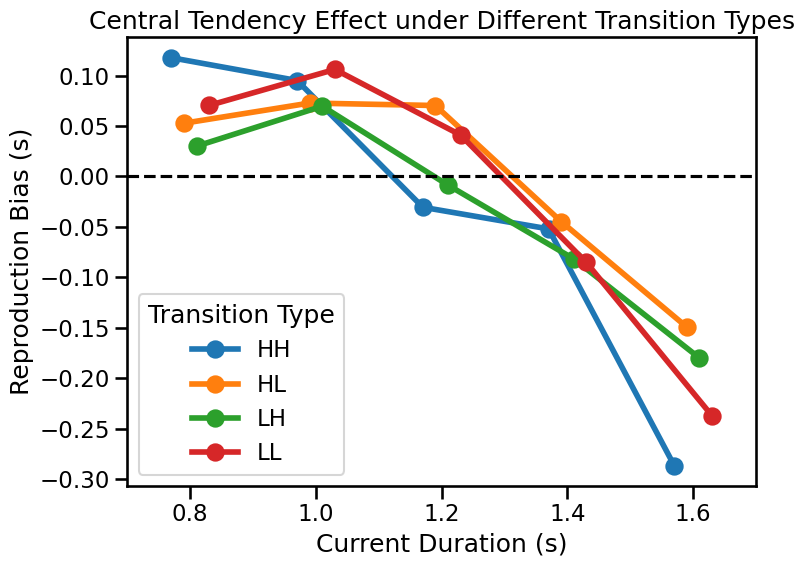

In [343]:

# Group by TransitionType & curDur 
bias_grouped = df.groupby(['TransitionType', 'curDur'])['curBias'] \
    .agg(['count', 'mean', 'sem']).reset_index()
bias_grouped.columns = ['TransitionType', 'curDur', 'count', 'mBias', 'seBias']

# plot
plt.figure(figsize=(8, 6))
sns.pointplot(data=bias_grouped,
              x='curDur', y='mBias', hue='TransitionType',
              dodge=0.3, capsize=0.1, errwidth=1.2)
plt.axhline(0, color='black', linestyle='--')
plt.title("Central Tendency Effect under Different Transition Types")
plt.xlabel("Current Duration (s)")
plt.ylabel("Reproduction Bias (s)")
plt.legend(title="Transition Type")
plt.tight_layout()
plt.show()

## 4 Sequential effect or Serial dependence


   preDur1back  count     mBias    seBias
0          0.8      2 -0.063225  0.026492
1          1.0      2 -0.093517  0.002075
2          1.2      2 -0.038136  0.032798
3          1.4      2  0.003160  0.032423
4          1.6      2  0.063449  0.037647


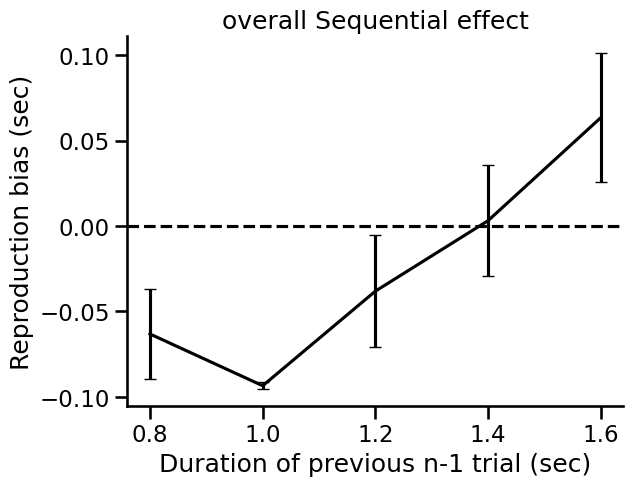

In [344]:
# overall Sequential effect (based on Reproduction Bias)
mBiasPreDurPar = df.groupby(['subID','preDur1back']).curBias.mean().reset_index()
mBiasPreDurAll = mBiasPreDurPar.groupby('preDur1back').\
    agg({"curBias":["count","mean","sem"]}).reset_index()
mBiasPreDurAll.columns = ['preDur1back', 'count', 'mBias','seBias']
print(mBiasPreDurAll)

# rmANOVA: mean bias as a factor of pre-duration
#print('【rmANOVA of mean Bias on preDuration】')
#aov_bias_preDur = rmANOVA_gg_Long(mBiasPreDurPar, 'curBias', ['preDur1back'], 'subID')
#print(aov_bias_preDur)

# plot sequential effect
fig, ax = plt.subplots()
plt.errorbar(x='preDur1back', y='mBias', yerr='seBias', data=mBiasPreDurAll, 
             color='black', capsize=4)
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(mBiasPreDurAll.preDur1back)
plt.xlabel('Duration of previous n-1 trial (sec)')
plt.ylabel('Reproduction bias (sec)')
plt.title('overall Sequential effect')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

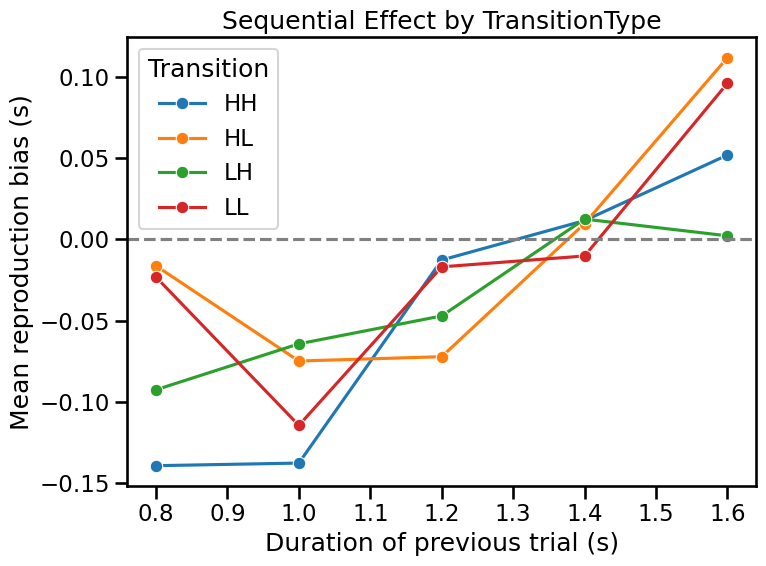

In [345]:
mBias_byTrans = df.groupby(['subID', 'TransitionType', 'preDur1back'])['curBias'].mean().reset_index()


# 再聚合：TransitionType × preDur
mBias_byTrans_all = mBias_byTrans.groupby(['TransitionType', 'preDur1back']).agg(
    count=('curBias', 'count'),
    mBias=('curBias', 'mean'),
    seBias=('curBias', 'sem')
).reset_index()
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.lineplot(
    data=mBias_byTrans_all,
    x='preDur1back',
    y='mBias',
    hue='TransitionType',
    marker='o', err_style="bars", err_kws={'capsize': 4}
)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Duration of previous trial (s)')
plt.ylabel('Mean reproduction bias (s)')
plt.title('Sequential Effect by TransitionType')
plt.legend(title='Transition')
plt.tight_layout()
plt.show()

Text(0.5, 0.98, 'Serial Dependence by Previous Duration and Transition Type')

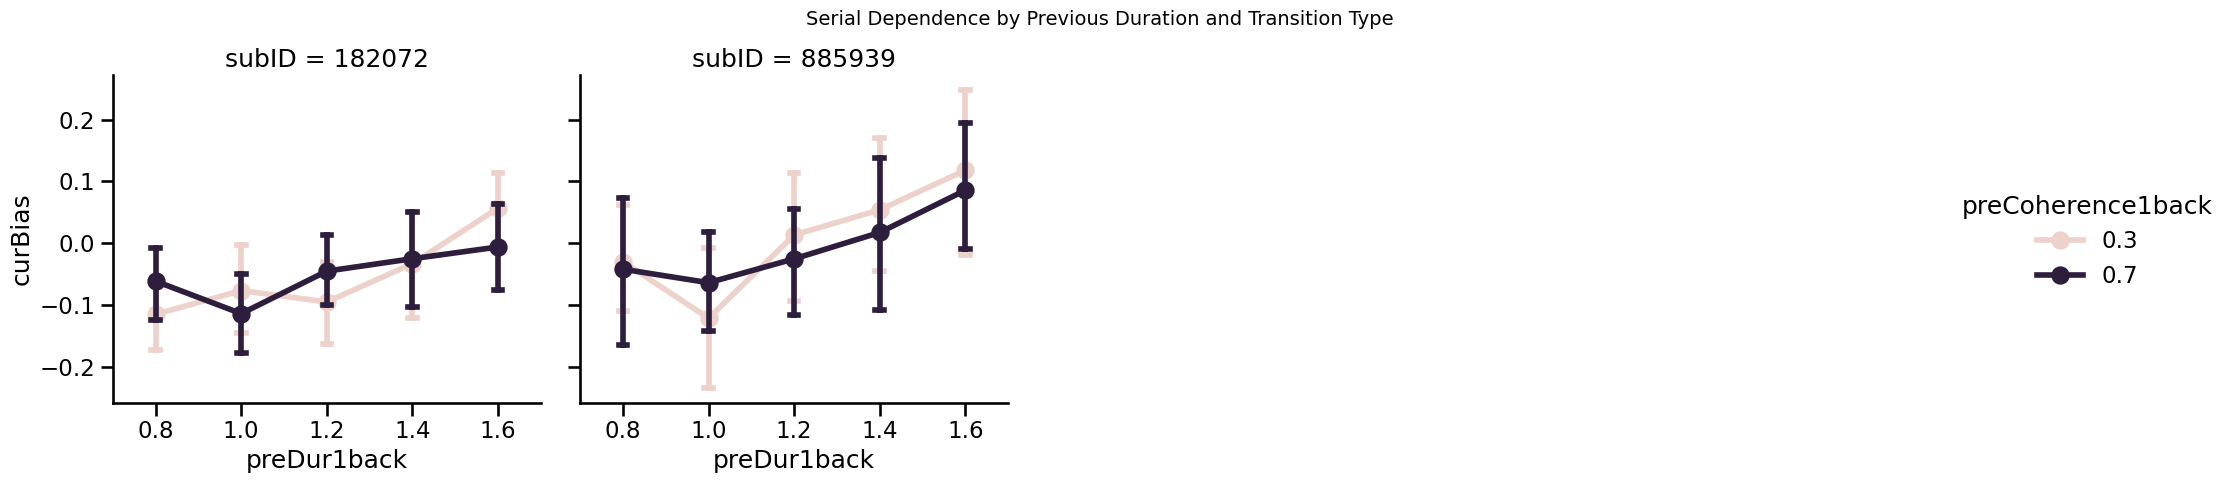

In [346]:
sns.catplot(
    data=df,   
      kind='point', x='preDur1back', y='curBias', hue='preCoherence1back', col='subID',    col_wrap=4,    capsize=0.1,    height=5,  
)

plt.subplots_adjust(top=0.85)
plt.suptitle("Serial Dependence by Previous Duration and Transition Type", fontsize=14)

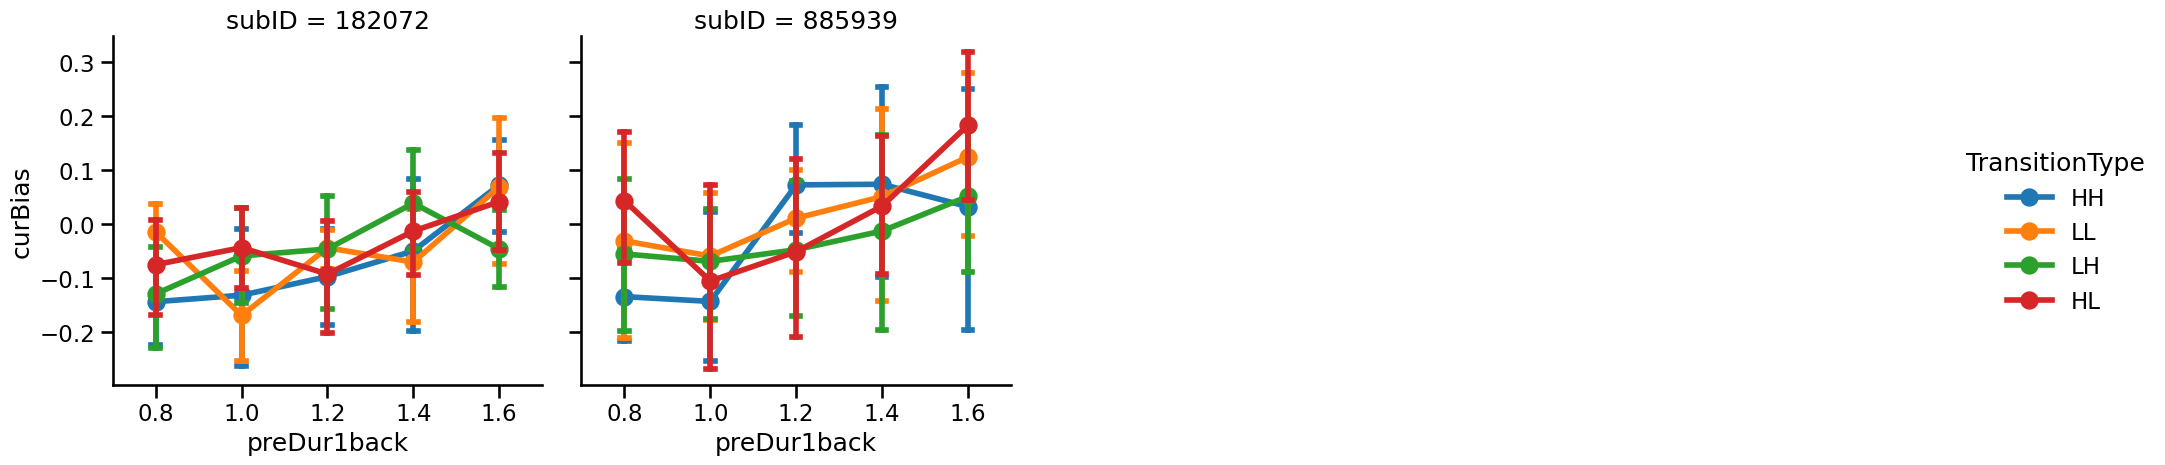

In [347]:
sns.catplot(
    data=df,   
      kind='point', x='preDur1back', y='curBias', hue='TransitionType', col='subID',    col_wrap=4,    capsize=0.1,    height=5,  
)

    subID TransitionType     slope
0  182072             HH  0.249802
1  182072             HL  0.131882
2  182072             LH  0.107871
3  182072             LL  0.095993
4  885939             HH  0.271844
\defferent transition type slopes:
TransitionType
HH    0.260823
HL    0.178898
LH    0.124230
LL    0.153046
Name: slope, dtype: float64


<>:17: SyntaxWarning: invalid escape sequence '\d'
<>:17: SyntaxWarning: invalid escape sequence '\d'
C:\Users\10993\AppData\Local\Temp\ipykernel_54200\1825355859.py:17: SyntaxWarning: invalid escape sequence '\d'
  print("\defferent transition type slopes:")


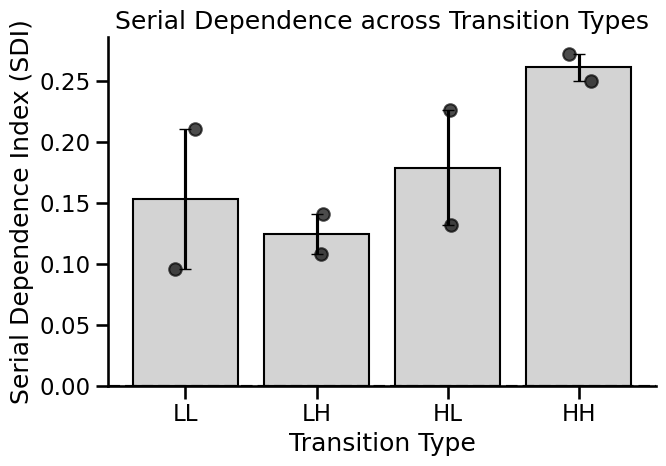


LL vs HH
            T  dof alternative  p-val          CI95%  cohen-d   BF10  power
T-test -2.341    1   two-sided  0.257  [-0.69, 0.48]    1.855  1.137  0.163

HL vs LH
            T  dof alternative  p-val          CI95%  cohen-d   BF10  power
T-test  1.783    1   two-sided  0.325  [-0.33, 0.44]    1.098  0.979    0.1

HH vs LH
             T  dof alternative  p-val        CI95%  cohen-d   BF10 power
T-test  25.593    1   two-sided  0.025  [0.07, 0.2]    6.925  2.944   NaN

LL vs HL
            T  dof alternative  p-val         CI95%  cohen-d   BF10  power
T-test -2.576    1   two-sided  0.236  [-0.15, 0.1]     0.35  1.198  0.056


In [348]:
import statsmodels.api as sm
slopes = []
for (sub_id, trans_type), group in df.groupby(['subID', 'TransitionType']):
    if len(group) >= 5: 
        X = group[ 'preDur1back']
        y = group['curBias']
        X = sm.add_constant(X) 
        model = sm.OLS(y, X).fit()
        slope = model.params['preDur1back']
        
        slopes.append({'subID': sub_id,'TransitionType': trans_type,'slope': slope })
df_slopes = pd.DataFrame(slopes)
print(df_slopes.head())
#  2. mean and sem
mean_slopes = df_slopes.groupby('TransitionType')['slope'].mean()
sem_slopes = df_slopes.groupby('TransitionType')['slope'].sem()
print("\defferent transition type slopes:")
print(mean_slopes)
# plot
fig, ax = plt.subplots(figsize=(7,5))

transition_order = ['LL', 'LH', 'HL', 'HH']

x_pos = np.arange(len(transition_order))

ax.bar(x_pos, mean_slopes[transition_order], 
       yerr=sem_slopes[transition_order], 
       capsize=4, color='lightgrey', edgecolor='black')
# for each subject, plot a scatter point
for i, trans in enumerate(transition_order):
    y = df_slopes[df_slopes['TransitionType']==trans]['slope']
    jitter = (np.random.rand(len(y)) - 0.5) * 0.2
    ax.scatter(np.full_like(y, x_pos[i]) + jitter, y, color='black', alpha=0.7)

ax.set_xticks(x_pos)
ax.set_xticklabels(transition_order)
ax.axhline(0, color='black', linestyle='--')
ax.set_xlabel('Transition Type')
ax.set_ylabel('Serial Dependence Index (SDI)')
ax.set_title('Serial Dependence across Transition Types')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()
# t-test
print("\nLL vs HH")
ll = df_slopes.query('TransitionType == "LL"')['slope']
hh = df_slopes.query('TransitionType == "HH"')['slope']
print(pg.ttest(ll, hh, paired=True).round(3))
print("\nHL vs LH")
hl = df_slopes.query('TransitionType == "HL"')['slope']
lh = df_slopes.query('TransitionType == "LH"')['slope']
print(pg.ttest(hl, lh, paired=True).round(3))
print("\nHH vs LH")
hl = df_slopes.query('TransitionType == "HH"')['slope']
lh = df_slopes.query('TransitionType == "LH"')['slope']
print(pg.ttest(hl, lh, paired=True).round(3))
print("\nLL vs HL")
ll = df_slopes.query('TransitionType == "LL"')['slope']
hl = df_slopes.query('TransitionType == "HL"')['slope']
print(pg.ttest(ll, hl, paired=True).round(3))


In [349]:
def compare_SDI_two_conditions(df, cond_col, cond_vals, 
                               x_predict='preDur1back',
                               
                               y_target='curBias', 
                               group_col='subID', condition_names=('Cond1', 'Cond2'),
                               title='Serial Dependence Index Comparison'):
    """
    compare
    """

    df = df.copy()

    data1 = df[df[cond_col] == cond_vals[0]]
    data2 = df[df[cond_col] == cond_vals[1]]
   
    def get_slopes(data):
        slopes = []
        for sid, dsub in data.groupby(group_col):
            if dsub.shape[0] >= 5:
                slope = np.polyfit(dsub[x_predict], dsub[y_target], 1)[0]
                slopes.append(slope)
        return np.array(slopes)

    slope1 = get_slopes(data1)
    slope2 = get_slopes(data2)

    n = min(len(slope1), len(slope2))
    slope1 = slope1[:n]
    slope2 = slope2[:n]

    print(f"SDI ({condition_names[0]}): Mean = {slope1.mean():.3f}, SE = {slope1.std()/np.sqrt(n):.3f}")
    print(pg.ttest(slope1, 0).round(4))
    print(f" SDI ({condition_names[1]}): Mean = {slope2.mean():.3f}, SE = {slope2.std()/np.sqrt(n):.3f}")
    print(pg.ttest(slope2, 0).round(4))
    print(f" Paired comparison ({condition_names[0]} vs {condition_names[1]}):")
    print(pg.ttest(slope1, slope2, paired=True).round(4))

    X = np.arange(1, 3)
    Y = [slope1.mean(), slope2.mean()]
    yerr = [slope1.std()/np.sqrt(n), slope2.std()/np.sqrt(n)]

    fig, ax = plt.subplots(figsize=(6, 5))
    plt.bar(X, Y, color='lightgray', width=0.5)
    plt.errorbar(X, Y, yerr=yerr, color='black', capsize=4, linestyle='')

    jitter = (np.random.rand(n, 2) - 0.5) * 0.3
    plt.scatter(jitter[:,0]+1, slope1, color='black', alpha=0.8)
    plt.scatter(jitter[:,1]+2, slope2, color='black', alpha=0.8)

    plt.axhline(y=0, color='black', linestyle='--')
    plt.xticks(X, condition_names)
    plt.ylabel('Serial Dependence Index (slope)')
    plt.xlabel(cond_col)
    plt.title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # p
    p_val = pg.ttest(slope1, slope2, paired=True)['p-val'].values[0]
    label_text = f'p = {p_val:.3f}' if p_val >= 0.001 else 'p < .001'
    ax.annotate(label_text, xy=(1.5, max(Y)*1.2), ha='center')
    ax.plot([1,2], [max(Y)*1.1]*2, color='black')
    ax.vlines([1,2], max(Y)*1.05, max(Y)*1.1, color='black')

    plt.tight_layout()
    plt.show()


SDI (high uncertainty): Mean = 0.191, SE = 0.005
              T  dof alternative   p-val         CI95%  cohen-d   BF10   power
T-test  24.7855    1   two-sided  0.0257  [0.09, 0.29]   17.526  2.919  0.9482
 SDI (low uncertainty): Mean = 0.167, SE = 0.036
             T  dof alternative   p-val          CI95%  cohen-d   BF10   power
T-test  3.2649    1   two-sided  0.1892  [-0.48, 0.82]   2.3086  1.357  0.2022
 Paired comparison (high uncertainty vs low uncertainty):
             T  dof alternative   p-val          CI95%  cohen-d BF10   power
T-test  0.5577    1   two-sided  0.6761  [-0.53, 0.58]   0.4683  0.6  0.0605


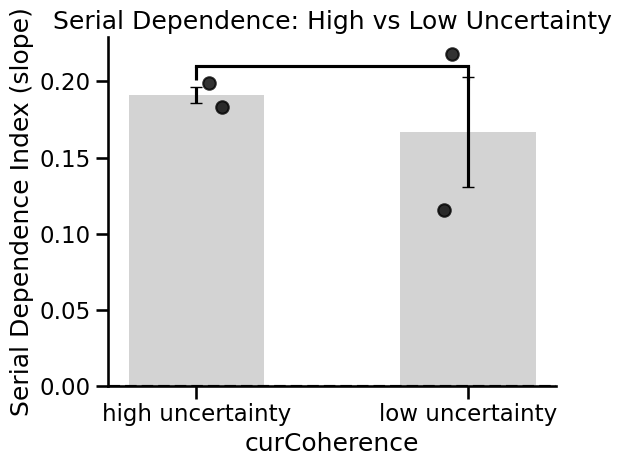

In [350]:

compare_SDI_two_conditions(
    df=df,
    cond_col='curCoherence',
    cond_vals=[0.3, 0.7],  
    condition_names=['high uncertainty', 'low uncertainty'],
    title='Serial Dependence: High vs Low Uncertainty'
)


## 5 decisional carryover effect

In [351]:
def compute_preRpt(df):
    df = df.copy()
    df['sameDur'] = (df['curDur'] == df['preDur1back']).astype(int)
    df['preRpt'] = 0

    for sub_id, group in df.groupby('subID'):
        count_list = []
        count = 0
        for same in group['sameDur']:
            count = count + 1 if same else 0
            count_list.append(count)
        df.loc[group.index, 'preRpt'] = count_list

    return df



In [352]:
df = compute_preRpt(df)


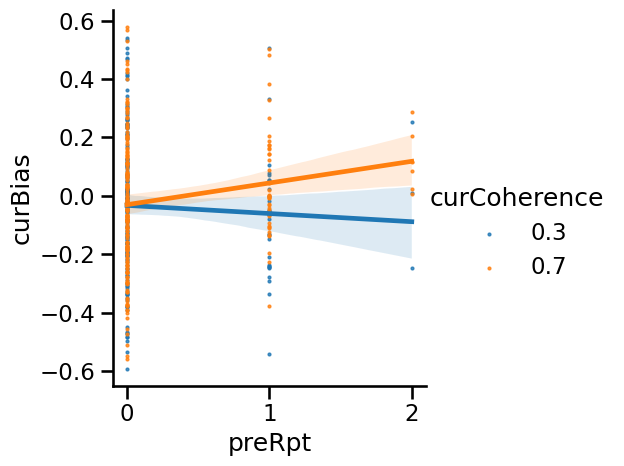

In [353]:

sns.set_context("talk")

g = sns.lmplot(
    data=df.query('preRpt < 3'),
    x="preRpt", y="curBias", hue='curCoherence',
    scatter_kws={"s": 4}
)




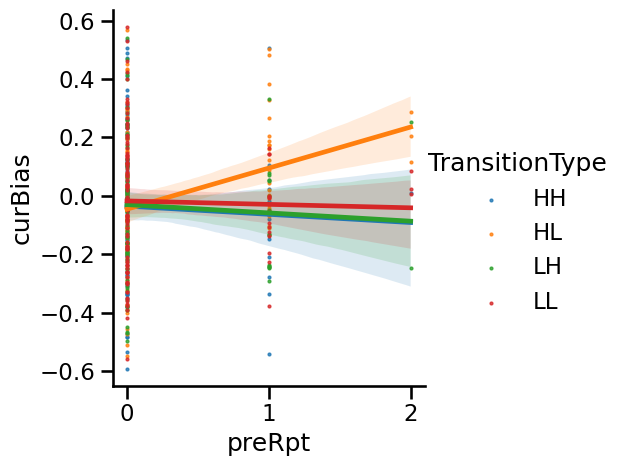

In [354]:

sns.set_context("talk")

g = sns.lmplot(
    data=df.query('preRpt < 3'),
    x="preRpt", y="curBias", hue='TransitionType',
    scatter_kws={"s": 4}
)


## 6 n-back serial dependence

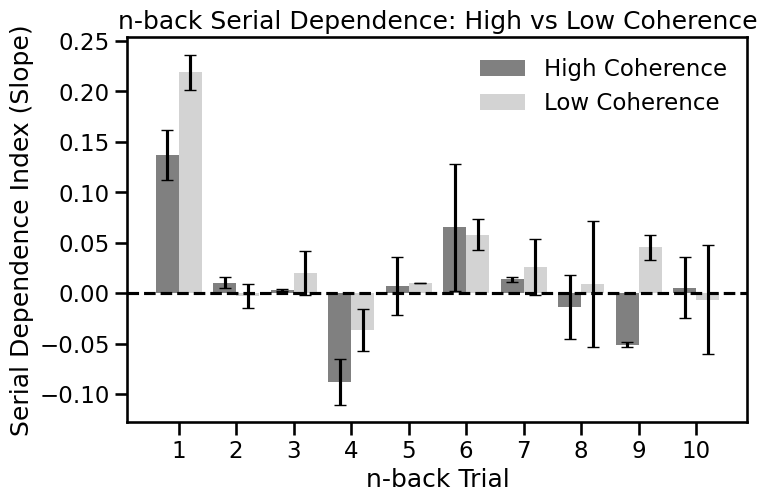

In [355]:
max_n_back = 10 

# 
dur_cols_list = [f'preDur{i}back' for i in range(1, max_n_back + 1)]
coh_cols_list = [f'preCoherence{i}back' for i in range(1, max_n_back + 1)]

# 
mean_sdi_high = []
se_sdi_high = []
mean_sdi_low = []
se_sdi_low = []

# N
nPar = df['subID'].nunique()

#  n-back 
for dur_col, coh_col in zip(dur_cols_list, coh_cols_list):
    # （High coherence = 0.7）
    data_high = df[df[coh_col] == 0.7]
    # （Low coherence = 0.3）
    data_low = df[df[coh_col] == 0.3]

    # （preDur → curBias）
    def calc_sdi(data):
        slopes = []
        for sid, df_sub in data.groupby('subID'):
            if df_sub.shape[0] >= 5:  # 至少5个点
                slope = np.polyfit(df_sub[dur_col], df_sub['curBias'], 1)[0]
                slopes.append(slope)
        return np.array(slopes)

    sdi_high = calc_sdi(data_high)
    sdi_low = calc_sdi(data_low)

    mean_sdi_high.append(np.mean(sdi_high))
    se_sdi_high.append(np.std(sdi_high) / np.sqrt(len(sdi_high)))
    mean_sdi_low.append(np.mean(sdi_low))
    se_sdi_low.append(np.std(sdi_low) / np.sqrt(len(sdi_low)))


x = np.arange(1, max_n_back + 1)
plt.figure(figsize=(8,5))
plt.bar(x-0.2, mean_sdi_high, width=0.4, color='gray', label="High Coherence")
plt.bar(x+0.2, mean_sdi_low, width=0.4, color='lightgray', label="Low Coherence")

plt.errorbar(x-0.2, mean_sdi_high, yerr=se_sdi_high, fmt='none', color='black', capsize=4)
plt.errorbar(x+0.2, mean_sdi_low, yerr=se_sdi_low, fmt='none', color='black', capsize=4)

plt.axhline(0, linestyle='--', color='black')
plt.xticks(x)
plt.xlabel('n-back Trial')
plt.ylabel('Serial Dependence Index (Slope)')
plt.title('n-back Serial Dependence: High vs Low Coherence')
plt.legend(frameon=False)
plt.grid(False)
plt.show()


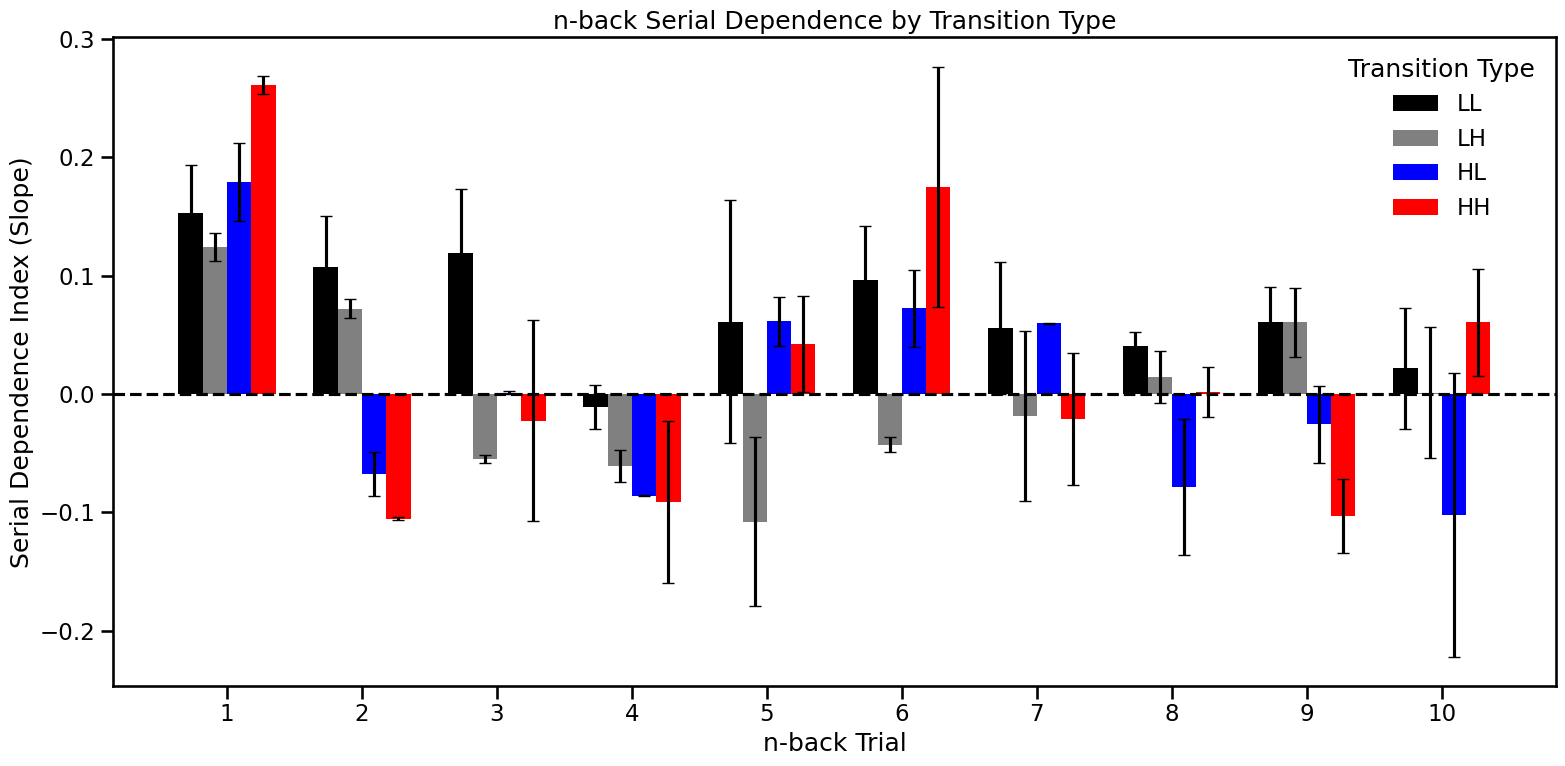

In [356]:
transitions = ['LL', 'LH', 'HL', 'HH']
sdi_results = {t: {'mean': [], 'se': []} for t in transitions}


# slope
for dur_col in dur_cols_list:
    for t in transitions:
        data_t = df[df['TransitionType'] == t]

        def calc_sdi(data):
            slopes = []
            for sid, df_sub in data.groupby('subID'):
                if df_sub.shape[0] >= 5 and dur_col in df_sub.columns:
                   
                    df_sub = df_sub.dropna(subset=[dur_col, 'curBias'])
                    if df_sub.shape[0] >= 5:
                        slope = np.polyfit(df_sub[dur_col], df_sub['curBias'], 1)[0]
                        slopes.append(slope)
            return np.array(slopes)

        sdi = calc_sdi(data_t)
        sdi_results[t]['mean'].append(np.mean(sdi))
        sdi_results[t]['se'].append(np.std(sdi) / np.sqrt(len(sdi)))

# visualization
x = np.arange(1, max_n_back + 1)
bar_width = 0.18
colors = {'LL': 'black', 'LH': 'gray', 'HL': 'blue', 'HH': 'red'}

plt.figure(figsize=(16, 8))
for i, t in enumerate(transitions):
    plt.bar(x + (i - 1.5) * bar_width,
            sdi_results[t]['mean'],
            width=bar_width,
            label=t,
            color=colors[t])
    
    plt.errorbar(x + (i - 1.5) * bar_width,
                 sdi_results[t]['mean'],
                 yerr=sdi_results[t]['se'],
                 fmt='none',
                 capsize=4,
                 color='black')

plt.axhline(0, linestyle='--', color='black')
plt.xticks(x)
plt.xlabel('n-back Trial')
plt.ylabel('Serial Dependence Index (Slope)')
plt.title('n-back Serial Dependence by Transition Type')
plt.legend(title="Transition Type", frameon=False)
plt.grid(False)
plt.tight_layout()
plt.show()


## 7 Linear mixed model


In [357]:
import statsmodels.formula.api as smf
model_simple = smf.mixedlm(
    "curBias ~ preDur1back",       # TimeDur_prev
    data=df,                # 
    groups=df["subID"]       # 
)

# 2. 拟合模型
result_simple = model_simple.fit()

# 3. 打印模型结果
print(result_simple.summary())


        Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: curBias
No. Observations:  447     Method:             REML   
No. Groups:        2       Scale:              0.0473 
Min. group size:   211     Log-Likelihood:     41.8732
Max. group size:   236     Converged:          Yes    
Mean group size:   223.5                              
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept   -0.237    0.052 -4.593 0.000 -0.339 -0.136
preDur1back  0.176    0.037  4.798 0.000  0.104  0.248
Group Var    0.001    0.009                           



c:\Users\10993\.conda\envs\pymc_env\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [358]:

df['Uncertainty'] = df['curCoherence'].apply(lambda x: 'High' if x == 0.3 else 'Low')


import statsmodels.formula.api as smf

model = smf.mixedlm(    "curBias ~ preDur1back * Uncertainty",
    data=df,
    groups=df["subID"]
).fit()


print(model.summary())


                  Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       curBias
No. Observations:         447           Method:                   REML   
No. Groups:               2             Scale:                    0.0473 
Min. group size:          211           Log-Likelihood:           38.2360
Max. group size:          236           Converged:                Yes    
Mean group size:          223.5                                          
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                      -0.269    0.070 -3.839 0.000 -0.406 -0.132
Uncertainty[T.Low]              0.056    0.091  0.611 0.541 -0.123  0.235
preDur1back                     0.190    0.052  3.629 0.000  0.087  0.293
preDur1back:Uncertainty[T.Low] -0.022    0.074 -0.304 0.

c:\Users\10993\.conda\envs\pymc_env\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [359]:
model = smf.mixedlm(
    "curBias ~ preDur1back * TransitionType",
    data=df,
    groups=df["subID"]
).fit()
print(model.summary())


                   Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        curBias
No. Observations:         447            Method:                    REML   
No. Groups:               2              Scale:                     0.0475 
Min. group size:          211            Log-Likelihood:            31.2305
Max. group size:          236            Converged:                 Yes    
Mean group size:          223.5                                            
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        -0.353    0.097 -3.645 0.000 -0.543 -0.163
TransitionType[T.HL]              0.131    0.130  1.007 0.314 -0.124  0.386
TransitionType[T.LH]              0.165    0.132  1.252 0.211 -0.093  0.423
TransitionType[T.LL]           

c:\Users\10993\.conda\envs\pymc_env\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [360]:
for t in ['LL', 'LH', 'HL', 'HH']:
    model = smf.mixedlm("curBias ~ preDur1back", data=df[df['TransitionType']==t], groups="subID").fit()
    print(f"--- {t} ---")
    print(model.summary())


--- LL ---
        Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: curBias
No. Observations:  110     Method:             REML   
No. Groups:        2       Scale:              0.0466 
Min. group size:   52      Log-Likelihood:     8.4104 
Max. group size:   58      Converged:          Yes    
Mean group size:   55.0                               
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept   -0.203    0.093 -2.173 0.030 -0.385 -0.020
preDur1back  0.155    0.073  2.131 0.033  0.012  0.298
subID Var    0.002    0.016                           

--- LH ---
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: curBias
No. Observations: 114     Method:             REML   
No. Groups:       2       Scale:              0.0432 
Min. group size:  56      Log-Likelihood:     inf    
Max. grou

c:\Users\10993\.conda\envs\pymc_env\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\10993\.conda\envs\pymc_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\10993\.conda\envs\pymc_env\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\10993\.conda\envs\pymc_env\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\10993\.conda\envs\pymc_env\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn

## 8 DVI

In [366]:
df.head()

,subID,trial_num,curDur,rpr,curBias,curCoherence,preDur1back,preCoherence1back,TransitionType,preDur2back,...,preCoherence4back,preCoherence5back,preCoherence6back,preCoherence7back,preCoherence8back,preCoherence9back,preCoherence10back,sameDur,preRpt,Uncertainty
1,182072,31,1.6,1.1146,-0.4854,0.3,1.4,0.3,HH,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,High
2,182072,33,1.0,0.7059,-0.2941,0.7,1.6,0.3,HL,1.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,Low
3,182072,34,0.8,0.6063,-0.1937,0.3,1.0,0.7,LH,1.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,High
4,182072,35,1.2,0.6638,-0.5362,0.3,0.8,0.3,HH,1.0,...,0.3,NaN,NaN,NaN,NaN,NaN,NaN,0,0,High
5,182072,36,1.4,1.0245,-0.3755,0.7,1.2,0.3,HL,0.8,...,0.3,0.3,NaN,NaN,NaN,NaN,NaN,0,0,Low


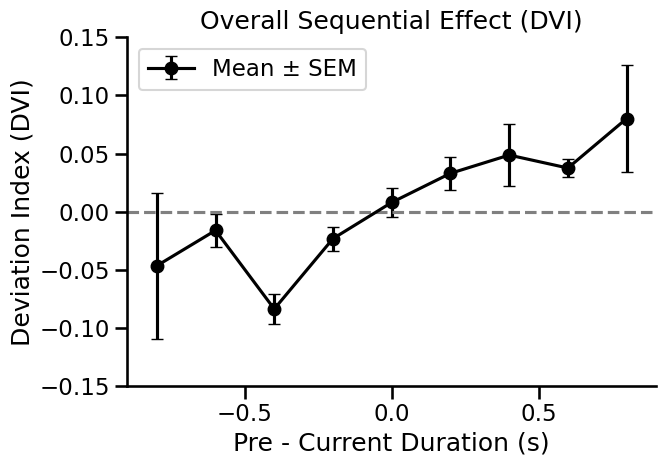

In [369]:
plot_dvi_curve(df)


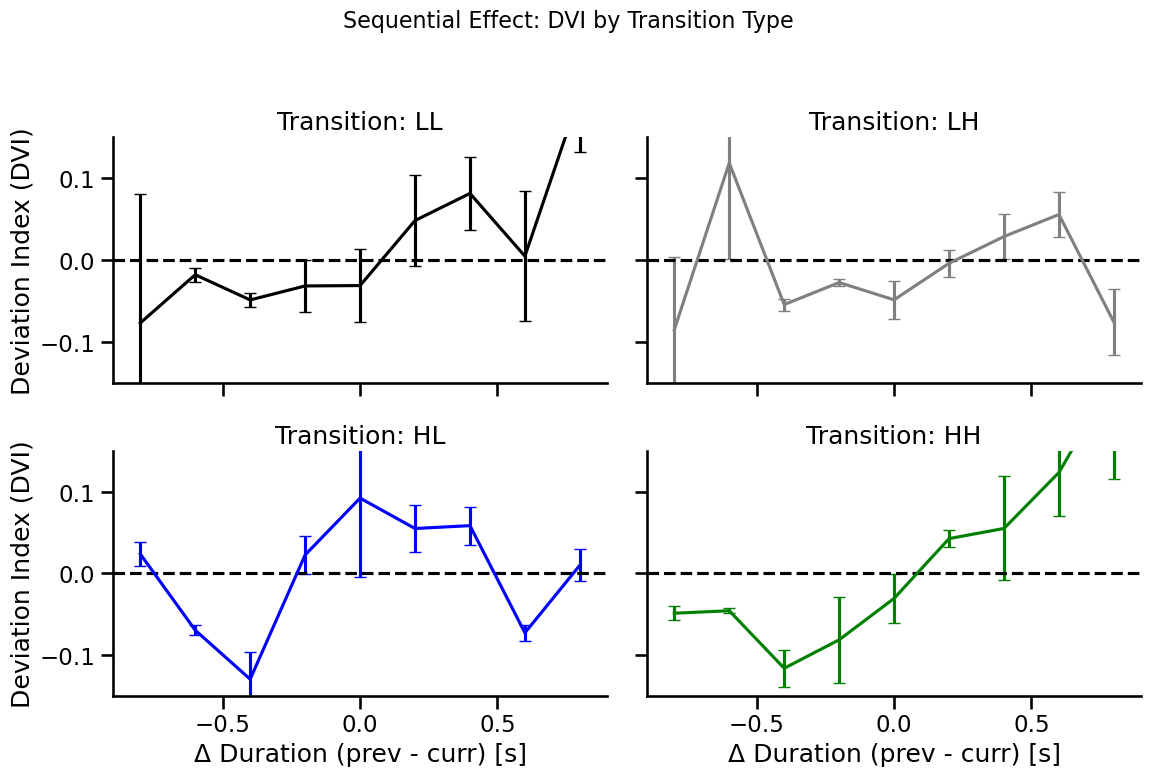

In [370]:
plot_dvi_curve(df, by_transition=True)
